<a href="https://colab.research.google.com/github/MinaBeric/Market_Basket_Analysis/blob/main/Market_basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spark Context creation**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

In [2]:
import pyspark
sc=spark.sparkContext
from pyspark.sql import functions as F

# **Import Dataset from Kaggle**

In [3]:
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d "asaniczka/1-3m-linkedin-jobs-and-skills-2024"

Dataset URL: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024
License(s): ODC Attribution License (ODC-By)
100% 1.88G/1.88G [01:09<00:00, 34.1MB/s]
100% 1.88G/1.88G [01:09<00:00, 29.1MB/s]


In [4]:
!unzip /content/1-3m-linkedin-jobs-and-skills-2024.zip -d data

Archive:  /content/1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: data/job_skills.csv     
  inflating: data/job_summary.csv    
  inflating: data/linkedin_job_postings.csv  


In [5]:
!rm /content/data/linkedin_job_postings.csv
!rm /content/data/job_summary.csv
!rm /content/1-3m-linkedin-jobs-and-skills-2024.zip


In [6]:
df = spark.read.options(header=True).csv('/content/data/job_skills.csv')
df.show()

+--------------------+--------------------+
|            job_link|          job_skills|
+--------------------+--------------------+
|https://www.linke...|Building Custodia...|
|https://www.linke...|Customer service,...|
|https://www.linke...|Applied Behavior ...|
|https://www.linke...|Electrical Engine...|
|https://www.linke...|Electrical Assemb...|
|https://www.linke...|Access Control, V...|
|https://www.linke...|Consultation, Sup...|
|https://www.linke...|Veterinary Recept...|
|https://www.linke...|Optical Inspectio...|
|https://www.linke...|HVAC, troubleshoo...|
|https://www.linke...|Host/Server Assis...|
|https://www.linke...|Apartment mainten...|
|https://www.linke...|Fiber Optic Cable...|
|https://www.linke...|CT Technologist, ...|
|https://ca.linked...|SAP, DRMIS, Data ...|
|https://www.linke...|Debt and equity o...|
|https://ca.linked...|Biomedical Engine...|
|https://www.linke...|Laboratory Techni...|
|https://www.linke...|Program Managemen...|
|https://www.linke...|Hiring, Tr

# **Data pre processing and EDA**

In [7]:
df.describe()

summary,job_link,job_skills
count,1296381,1294374
mean,null,null
stddev,null,null
min,https://ae.linked...,"""* Maintenance, *..."
max,https://za.linked...,"志愿服务, 沟通, 陪伴, 临终服..."


In [8]:
df=df.dropna()

In [9]:
df.select("job_skills").show(10)

+--------------------+
|          job_skills|
+--------------------+
|Building Custodia...|
|Customer service,...|
|Applied Behavior ...|
|Electrical Engine...|
|Electrical Assemb...|
|Access Control, V...|
|Consultation, Sup...|
|Veterinary Recept...|
|Optical Inspectio...|
|HVAC, troubleshoo...|
+--------------------+
only showing top 10 rows



In [10]:
df_skillcounts = df.withColumn("job_skill", F.explode(F.split(F.col("job_skills"), ", ")))
df_skillcounts = df_skillcounts.groupBy("job_skill").count()
top_skills = df_skillcounts.orderBy(F.desc("count")).limit(10)
top_skills.show()

+--------------------+------+
|           job_skill| count|
+--------------------+------+
|       Communication|368202|
|            Teamwork|226205|
|          Leadership|184292|
|    Customer service|166158|
|Communication skills|116169|
|    Customer Service|110400|
|     Problem Solving|102020|
|               Sales| 92718|
|      Problemsolving| 92489|
|             Nursing| 87419|
+--------------------+------+



**Sampling**

In [11]:
sample_fraction=0.01
df=df.sample(withReplacement=False, fraction=sample_fraction, seed=14)


In [12]:
df.count()

12977

# RDD Baskets creation

In [13]:
rdd_r0=df.select('job_skills').rdd.flatMap(lambda row: row)

In [14]:
rdd_r0.getNumPartitions()

6

In [15]:
rdd_r0.first()

'Nursing, Physician Assistant, Oncology, Hematology, Advanced Practice Registered Nurse, Advanced Practice Provider, Prescribing, Documentation, Referrals, Consultation, Patient Advocacy, Continuing Education, Research, Quality Improvement, Public Speaking, Teaching, Preceptorship, BLS Certification, CPR Certification, Cardiology, Pulmonary Medicine, Radiation Oncology, Hematology Oncology, Medical Oncology, Patient Care, Physical Examination, Diagnosis, Treatment Planning, Medication Management, Laboratory Testing, Imaging, Patient Education, Communication, Teamwork, Problem Solving, Critical Thinking, Decision Making, Professionalism, Ethics, Cultural Competence'

In [16]:
rdd_r1 = rdd_r0.map(lambda skills: skills.split(","))
rdd_r1.first()


['Nursing',
 ' Physician Assistant',
 ' Oncology',
 ' Hematology',
 ' Advanced Practice Registered Nurse',
 ' Advanced Practice Provider',
 ' Prescribing',
 ' Documentation',
 ' Referrals',
 ' Consultation',
 ' Patient Advocacy',
 ' Continuing Education',
 ' Research',
 ' Quality Improvement',
 ' Public Speaking',
 ' Teaching',
 ' Preceptorship',
 ' BLS Certification',
 ' CPR Certification',
 ' Cardiology',
 ' Pulmonary Medicine',
 ' Radiation Oncology',
 ' Hematology Oncology',
 ' Medical Oncology',
 ' Patient Care',
 ' Physical Examination',
 ' Diagnosis',
 ' Treatment Planning',
 ' Medication Management',
 ' Laboratory Testing',
 ' Imaging',
 ' Patient Education',
 ' Communication',
 ' Teamwork',
 ' Problem Solving',
 ' Critical Thinking',
 ' Decision Making',
 ' Professionalism',
 ' Ethics',
 ' Cultural Competence']

In [17]:
rdd_r1.count()

12977

# Creation of the Hash table

In [18]:
rdd_r2=rdd_r1.flatMap(lambda skills:skills).distinct()
rdd_r2.first()

' Advanced Practice Registered Nurse'

In [19]:
skill_to_index = rdd_r2.zipWithIndex().collectAsMap()

In [20]:
for key, value in list(skill_to_index.items())[:10]:
    print(f'Skill: {key}, Index: {value}')

Skill:  Advanced Practice Registered Nurse, Index: 0
Skill:  Preceptorship, Index: 1
Skill:  Medication Management, Index: 2
Skill:  Patient Education, Index: 3
Skill:  Interpersonal skills, Index: 4
Skill:  Communication skills, Index: 5
Skill:  Ability to work independently, Index: 6
Skill:  Upbeat and engaging personality, Index: 7
Skill:  Visual inspection, Index: 8
Skill:  High school diploma or equivalent, Index: 9


In [21]:
rdd_r3 = rdd_r1.map(lambda skills: {skill_to_index[skill] for skill in skills if skill in skill_to_index})

In [22]:
rdd_r3.first()

{0,
 1,
 2,
 3,
 17324,
 17325,
 17326,
 17327,
 17328,
 17329,
 17330,
 17331,
 34630,
 34631,
 34632,
 34633,
 34634,
 51907,
 51908,
 51909,
 51910,
 51911,
 69283,
 69284,
 69285,
 69286,
 69287,
 69288,
 69289,
 86474,
 86475,
 86476,
 86477,
 86478,
 86479,
 86480,
 86481,
 86482,
 86483,
 86484}

#**A PRIORI ALGORITHM**

**Support threshold**

In [23]:
#s = round(rdd_r1.count() * 0.01)

In [24]:
#s

By setting the support threshold with the usual 1% of the baskets, the time needed for the algorithm to produce results is too long (>20 minutes). For this reason s is set to be 1.5%

In [25]:
s=round((rdd_r1.count())*0.015)
s

195

In [26]:
support_percentage = (s / rdd_r1.count()) * 100

In [27]:
support_percentage

1.502658549741851

In [28]:
from itertools import combinations
import matplotlib.pyplot as plt

In [29]:
def apriori(baskets_collection, threshold_s, hash_table):
    itemset_counts = {}

    # Step 1: Find frequent singletons
    first_pass = (baskets_collection.flatMap(lambda basket: [(skill, 1) for skill in basket])  # Create (item, 1) pairs
                  .reduceByKey(lambda a, b: a + b)  # Sum counts for each item
                  .filter(lambda item_count: item_count[1] > threshold_s)  # Keep frequent items
    )

    first_count = first_pass.count()
    max_singleton = first_pass.max(lambda x: x[1])  # Singleton with the highest count
    most_frequent_skill = list(hash_table.keys())[list(hash_table.values()).index(max_singleton[0])]

    # Display frequent singletons
    print("Number of Frequent Singletons:", first_count)
    print("Most Frequent Singleton:", most_frequent_skill)

    frequents = set(first_pass.map(lambda x: (x[0],)).collect())

    # Store the total count of frequent singletons in itemset_counts
    itemset_counts["Size 1"] = first_count

    # Step 2: Find frequent itemsets of size 2, 3, and so on
    k = 2  # Start with pairs

    while True:
        # Generate candidate itemsets of size k
        candidate_itemsets = (baskets_collection.flatMap(lambda basket: [(elem, 1) for elem in combinations(sorted(basket), k)
                                       if all(item in frequents for item in combinations(elem, k-1))])  # Only take candidates with frequent subsets
                              .reduceByKey(lambda x, y: x + y)  # Count occurrences of each candidate
                              .filter(lambda x: x[1] > threshold_s)  # Keep only frequent itemsets
        )
        candidates_counts = candidate_itemsets.count()

        if candidates_counts != 0:
            print(f"Number of frequent itemsets of size {k} are", candidates_counts)

            max_itemsets = candidate_itemsets.max(lambda x: x[1])
            max_items = [list(hash_table.keys())[list(hash_table.values()).index(skill)] for skill in max_itemsets[0]]
            print(f"The Most frequent itemset of size {k} is", max_items)

            # Store the total count of frequent itemsets of size k in itemset_counts
            itemset_counts[f"Size {k}"] = candidates_counts

            # Update frequents for next iteration
            frequents = set(candidate_itemsets.map(lambda x: x[0]).collect())
            k += 1
        else:
            print(f"There are no more frequent itemsets of size {k}")
            break
    sizes=list(itemset_counts.keys())
    counts = list(itemset_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(sizes, counts, color='pink')
    plt.xlabel("Itemset Size")
    plt.ylabel("Count of Frequent Itemsets")
    plt.title("Count of Frequent Itemsets by Size")
    plt.show()





Number of Frequent Singletons: 96
Most Frequent Singleton:  Communication
Number of frequent itemsets of size 2 are 64
The Most frequent itemset of size 2 is [' Teamwork', ' Communication']
Number of frequent itemsets of size 3 are 9
The Most frequent itemset of size 3 is [' Teamwork', ' Leadership', ' Communication']
There are no more frequent itemsets of size 4


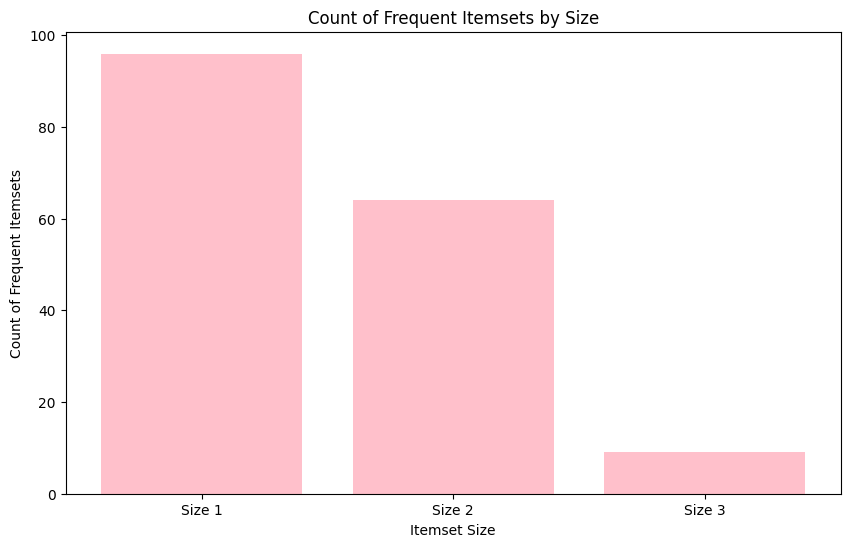

In [30]:
apriori(rdd_r3,s, skill_to_index)